Dataset shape (rows, columns): (301, 9)

--- First 5 records ---


,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0



--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB

--- Summary Statistics ---


,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
count,301,301.000000,301.000000,301.000000,301.000000,301,301,301,301.000000
unique,98,NaN,NaN,NaN,NaN,3,2,2,NaN
top,city,NaN,NaN,NaN,NaN,Petrol,Dealer,Manual,NaN
freq,26,NaN,NaN,NaN,NaN,239,195,261,NaN
mean,NaN,2013.627907,4.661296,7.628472,36947.205980,NaN,NaN,NaN,0.043189
std,NaN,2.891554,5.082812,8.644115,38886.883882,NaN,NaN,NaN,0.247915
min,NaN,2003.000000,0.100000,0.320000,500.000000,NaN,NaN,NaN,0.000000
25%,NaN,2012.000000,0.900000,1.200000,15000.000000,NaN,NaN,NaN,0.000000
50%,NaN,2014.000000,3.600000,6.400000,32000.000000,NaN,NaN,NaN,0.000000
75%,NaN,2016.000000,6.000000,9.900000,48767.000000,NaN,NaN,NaN,0.000000



Number of duplicate rows: 2
Shape after removing duplicates: (299, 9)

--- Unique values in categorical columns ---

Car_Name:
 Car_Name
city                  26
corolla altis         16
verna                 14
brio                  10
fortuner              10
                      ..
Honda Activa 125       1
Hero Hunk              1
Hero  Ignitor Disc     1
Hero  CBZ Xtreme       1
Bajaj  ct 100          1
Name: count, Length: 98, dtype: int64

Fuel_Type:
 Fuel_Type
Petrol    239
Diesel     58
CNG         2
Name: count, dtype: int64

Seller_Type:
 Seller_Type
Dealer        193
Individual    106
Name: count, dtype: int64

Transmission:
 Transmission
Manual       260
Automatic     39
Name: count, dtype: int64


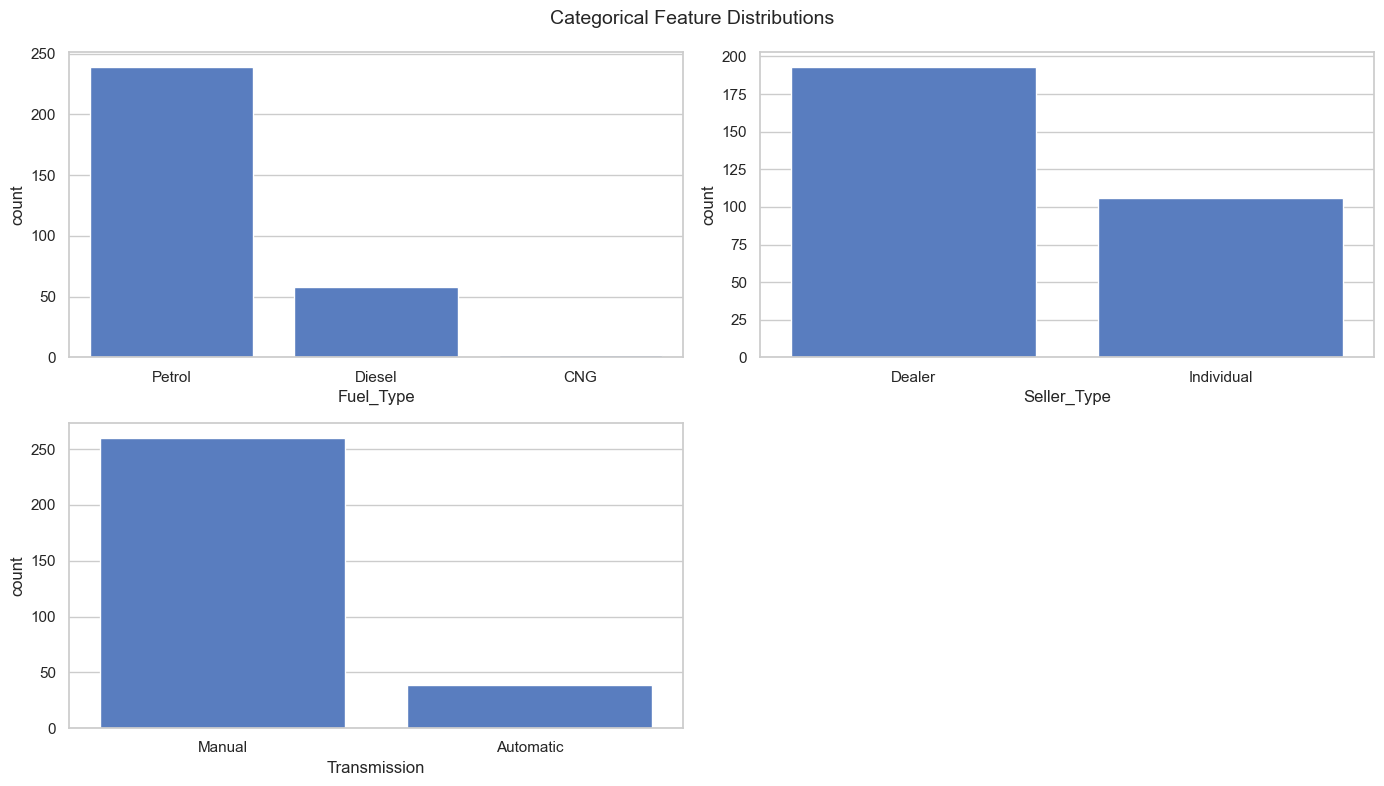


--- Numeric Feature Summary ---


,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,299.000000,299.000000,299.000000,299.000000,299.000000
mean,2013.615385,4.589632,7.541037,36916.752508,0.043478
std,2.896868,4.984240,8.567887,39015.170352,0.248720
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.850000,1.200000,15000.000000,0.000000
50%,2014.000000,3.510000,6.100000,32000.000000,0.000000
75%,2016.000000,6.000000,9.840000,48883.500000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


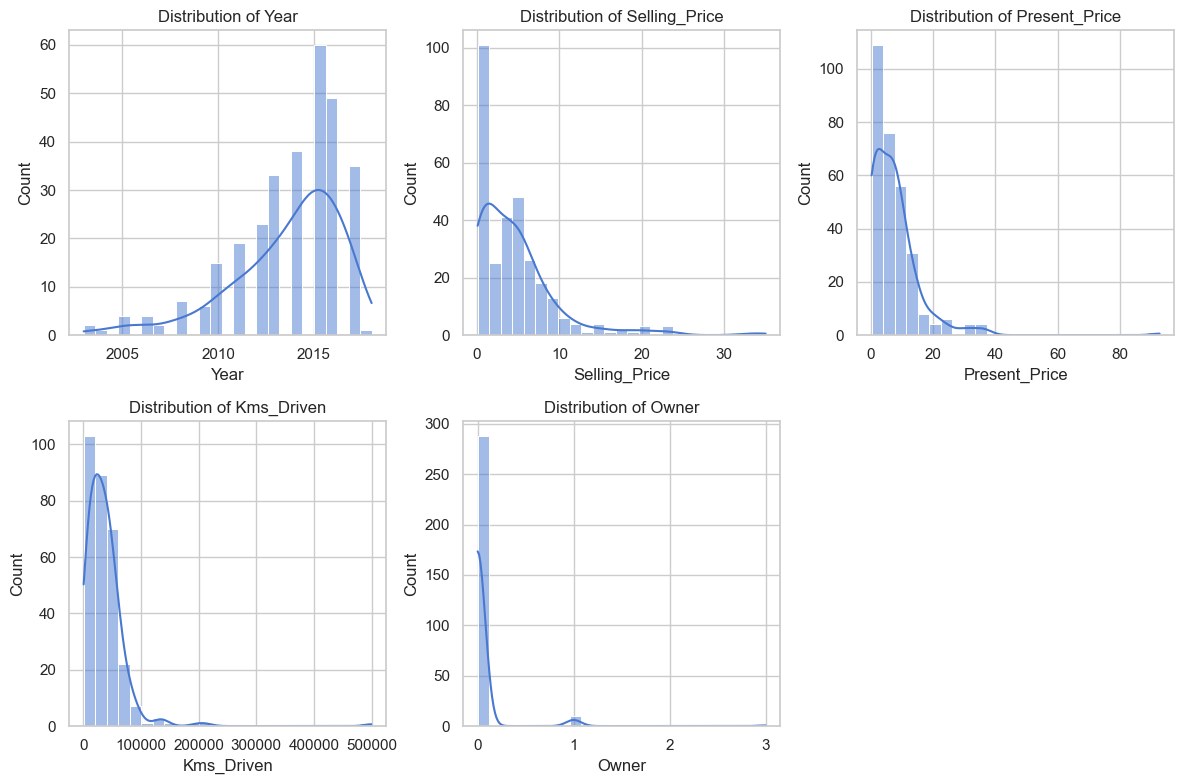

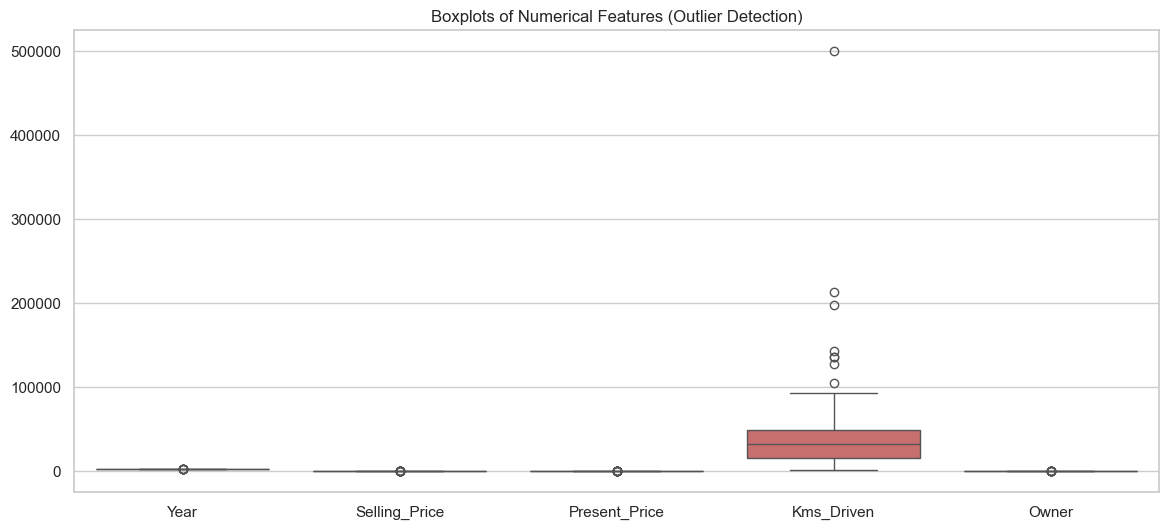

Shape after outlier removal: (291, 9)


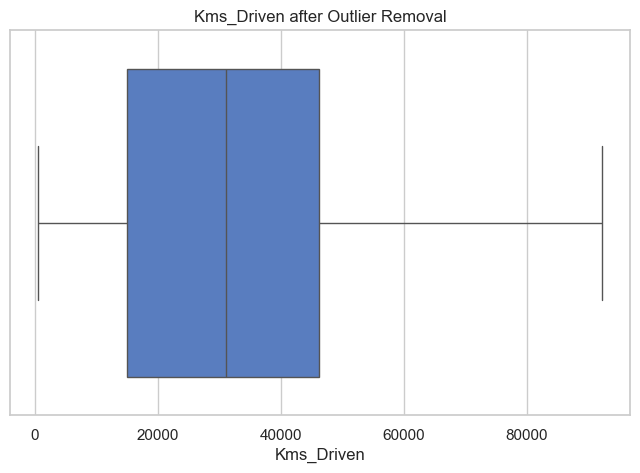

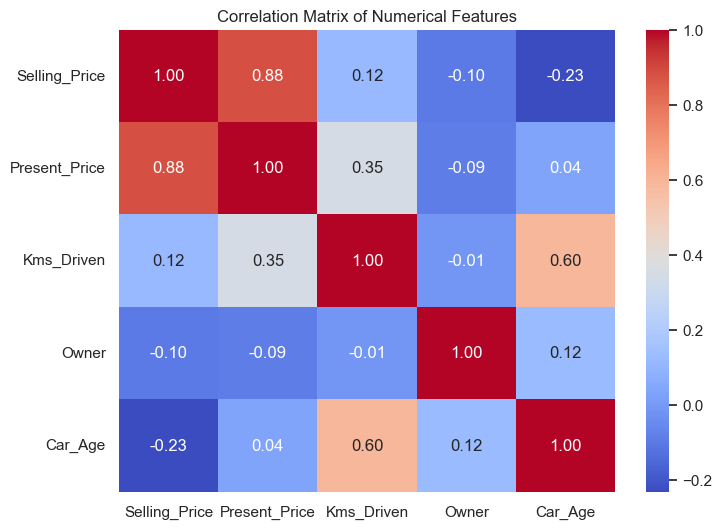

Encoded dataset preview:


,Car_Name,Selling_Price,Present_Price,Kms_Driven,Owner,Car_Age,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,ritz,3.35,5.59,27000,0,10,False,True,False,True
1,sx4,4.75,9.54,43000,0,11,True,False,False,True
2,ciaz,7.25,9.85,6900,0,7,False,True,False,True
3,wagon r,2.85,4.15,5200,0,13,False,True,False,True
4,swift,4.60,6.87,42450,0,10,True,False,False,True



Scaled numerical features:


,Car_Name,Selling_Price,Present_Price,Kms_Driven,Owner,Car_Age,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,ritz,-0.249298,-0.210940,-0.260552,0,-0.081716,False,True,False,True
1,sx4,0.034218,0.261269,0.485040,0,0.289836,True,False,False,True
2,ciaz,0.540498,0.298328,-1.197202,0,-1.196370,False,True,False,True
3,wagon r,-0.350554,-0.383087,-1.276421,0,1.032939,False,True,False,True
4,swift,0.003841,-0.057920,0.459410,0,-0.081716,True,False,False,True


Final dataset columns:
 ['Car_Name', 'Selling_Price', 'Present_Price', 'Kms_Driven', 'Owner', 'Car_Age', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Seller_Type_Individual', 'Transmission_Manual']
<class 'pandas.core.frame.DataFrame'>
Index: 291 entries, 0 to 300
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Car_Name                291 non-null    object 
 1   Selling_Price           291 non-null    float64
 2   Present_Price           291 non-null    float64
 3   Kms_Driven              291 non-null    float64
 4   Owner                   291 non-null    int64  
 5   Car_Age                 291 non-null    float64
 6   Fuel_Type_Diesel        291 non-null    bool   
 7   Fuel_Type_Petrol        291 non-null    bool   
 8   Seller_Type_Individual  291 non-null    bool   
 9   Transmission_Manual     291 non-null    bool   
dtypes: bool(4), float64(4), int64(1), object(1)
memory usage: 17.1+ K

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid", palette="muted")


df = pd.read_csv("cars.csv")
print("Dataset shape (rows, columns):", df.shape)
print("\n--- First 5 records ---")
display(df.head())

print("\n--- Dataset Info ---")
df.info()

print("\n--- Summary Statistics ---")
display(df.describe(include="all"))


duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")
df.drop_duplicates(inplace=True)
print("Shape after removing duplicates:", df.shape)


cat_cols = ['Car_Name', 'Fuel_Type', 'Seller_Type', 'Transmission']

print("\n--- Unique values in categorical columns ---")
for col in cat_cols:
    print(f"\n{col}:\n", df[col].value_counts())

# Visualize the distribution of categorical variables
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
sns.countplot(x='Fuel_Type', data=df, ax=axes[0,0])
sns.countplot(x='Seller_Type', data=df, ax=axes[0,1])
sns.countplot(x='Transmission', data=df, ax=axes[1,0])
axes[1,1].axis("off")
plt.suptitle("Categorical Feature Distributions", fontsize=14)
plt.tight_layout()
plt.show()


num_cols = ['Year', 'Selling_Price', 'Present_Price', 'Kms_Driven', 'Owner']
print("\n--- Numeric Feature Summary ---")
display(df[num_cols].describe())

# Histograms for numeric features
plt.figure(figsize=(12,8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2,3,i)
    sns.histplot(df[col], kde=True, bins=25)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# Boxplots for numeric features (to detect outliers visually)
plt.figure(figsize=(14,6))
sns.boxplot(data=df[num_cols])
plt.title("Boxplots of Numerical Features (Outlier Detection)")
plt.show()



# Convert car Year → Car Age
current_year = 2024
df['Car_Age'] = current_year - df['Year']
df.drop('Year', axis=1, inplace=True)

# Detect and filter out outliers in Kms_Driven using IQR
Q1 = df['Kms_Driven'].quantile(0.25)
Q3 = df['Kms_Driven'].quantile(0.75)
IQR = Q3 - Q1
low_limit = Q1 - 1.5 * IQR
high_limit = Q3 + 1.5 * IQR

df = df[(df['Kms_Driven'] >= low_limit) & (df['Kms_Driven'] <= high_limit)]
print("Shape after outlier removal:", df.shape)

# Visualize cleaned Kms_Driven column
plt.figure(figsize=(8,5))
sns.boxplot(x=df['Kms_Driven'])
plt.title("Kms_Driven after Outlier Removal")
plt.show()


plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()


df_encoded = pd.get_dummies(df, columns=['Fuel_Type','Seller_Type','Transmission'], drop_first=True)
print("Encoded dataset preview:")
display(df_encoded.head())


scaler = StandardScaler()
scale_cols = ['Selling_Price', 'Present_Price', 'Kms_Driven', 'Car_Age']

df_encoded[scale_cols] = scaler.fit_transform(df_encoded[scale_cols])
print("\nScaled numerical features:")
display(df_encoded.head())


print("Final dataset columns:\n", df_encoded.columns.tolist())
df_encoded.info()

# Visualize relationships between key numeric features
sns.pairplot(df_encoded[['Selling_Price','Present_Price','Kms_Driven','Car_Age']])
plt.suptitle("Pairplot of Continuous Variables (Scaled)", y=1.02)
plt.show()